This lab on Ridge Regression and the Lasso in R comes from p. 251-255 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It was re-implemented in Fall 2016 in `tidyverse` format by Amelia McNamara and R. Jordan Crouser at Smith College.

# 6.6: Ridge Regression and the Lasso

In [1]:
list.of.packages <- c("dplyr","ISLR","tidyr","glmnet")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

In [2]:
library(ISLR)
library(glmnet)
library(dplyr)
library(tidyr)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand



We will use the `glmnet` package in order to perform ridge regression and
the lasso. The main function in this package is `glmnet()`, which can be used
to fit ridge regression models, lasso models, and more. This function has
slightly different syntax from other model-fitting functions that we have
encountered thus far in this book. In particular, we must pass in an $x$
matrix as well as a $y$ vector, and we do not use the $y \sim x$ syntax.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [3]:
Hitters = na.omit(Hitters)

We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [4]:
x = model.matrix(Salary~., Hitters)[,-1] # trim off the first column
                                         # leaving only the predictors
y = Hitters %>%
  select(Salary) %>%
  unlist() %>%
  as.numeric()

The `model.matrix()` function is particularly useful for creating $x$; not only
does it produce a matrix corresponding to the 19 predictors but it also
automatically transforms any qualitative variables into dummy variables.
The latter property is important because `glmnet()` can only take numerical,
quantitative inputs.

# 6.6.1 Ridge Regression
The `glmnet()` function has an alpha argument that determines what type
of model is fit. If `alpha = 0` then a ridge regression model is fit, and if `alpha = 1`
then a lasso model is fit. We first fit a ridge regression model:

In [5]:
grid = 10^seq(10, -2, length = 100)
ridge_mod = glmnet(x, y, alpha = 0, lambda = grid)

By default the `glmnet()` function performs ridge regression for an automatically
selected range of $\lambda$ values. However, here we have chosen to implement
the function over a grid of values ranging from $\lambda = 10^{10}$ to $\lambda = 10^{-2}$, essentially covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit. 

As we will see, we can also compute
model fits for a particular value of $\lambda$ that is not one of the original
grid values. Note that by default, the `glmnet()` function standardizes the
variables so that they are on the same scale. To turn off this default setting,
use the argument `standardize = FALSE`.

Associated with each value of $\lambda$ is a vector of ridge regression coefficients,
stored in a matrix that can be accessed by `coef()`. In this case, it is a $20 \times 100$
matrix, with 20 rows (one for each predictor, plus an intercept) and 100
columns (one for each value of $\lambda$).

[1]  20 100

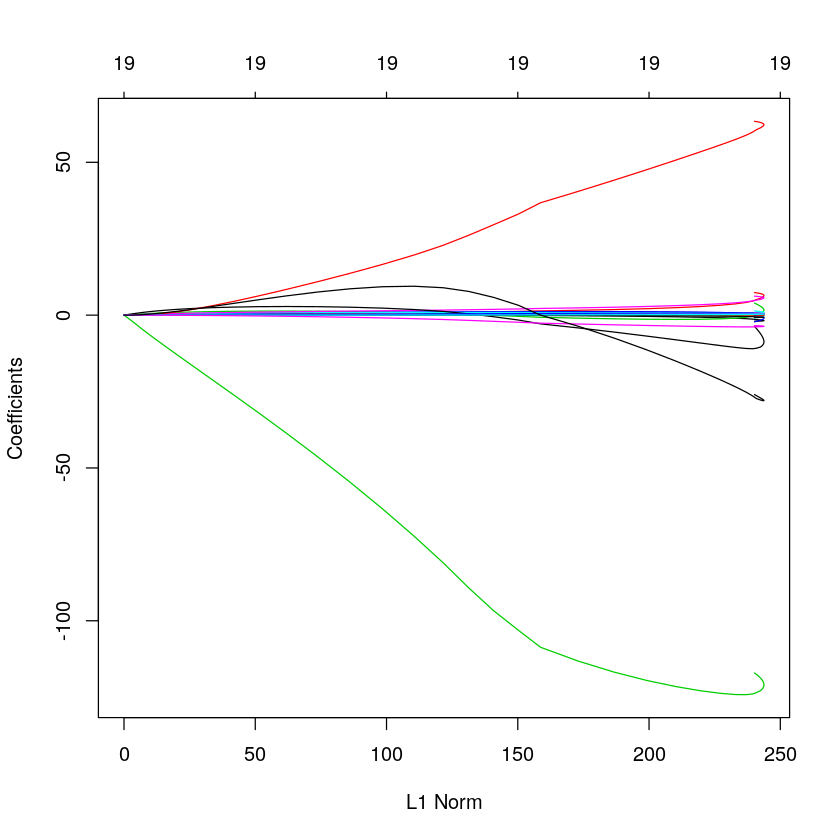

In [6]:
dim(coef(ridge_mod))
plot(ridge_mod)    # Draw plot of coefficients

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of $\lambda$ is used, as compared to when a small value of $\lambda$ is
used. These are the coefficients when $\lambda = 11498$, along with their $l_2$ norm:

In [7]:
ridge_mod$lambda[50] #Display 50th lambda value

[1] 11497.57

In [8]:
coef(ridge_mod)[,50] # Display coefficients associated with 50th lambda value

(Intercept)         AtBat          Hits         HmRun          Runs 
407.356050200   0.036957182   0.138180344   0.524629976   0.230701523 
          RBI         Walks         Years        CAtBat         CHits 
  0.239841459   0.289618741   1.107702929   0.003131815   0.011653637 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
  0.087545670   0.023379882   0.024138320   0.025015421   0.085028114 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
 -6.215440973   0.016482577   0.002612988  -0.020502690   0.301433531

In [9]:
sqrt(sum(coef(ridge_mod)[-1,50]^2)) # Calculate l2 norm

[1] 6.360612

In contrast, here are the coefficients when $\lambda = 705$, along with their $l_2$
norm. Note the much larger $l_2$ norm of the coefficients associated with this
smaller value of $\lambda$.

In [10]:
ridge_mod$lambda[60] #Display 60th lambda value
coef(ridge_mod)[,60] # Display coefficients associated with 60th lambda value
sqrt(sum(coef(ridge_mod)[-1,60]^2)) # Calculate l2 norm

[1] 705.4802

(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 54.32519950   0.11211115   0.65622409   1.17980910   0.93769713   0.84718546 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
  1.31987948   2.59640425   0.01083413   0.04674557   0.33777318   0.09355528 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  0.09780402   0.07189612  13.68370191 -54.65877750   0.11852289   0.01606037 
      Errors   NewLeagueN 
 -0.70358655   8.61181213

[1] 57.11001

We can use the `predict()` function for a number of purposes. For instance,
we can obtain the ridge regression coefficients for a new value of $\lambda$, say 50:

In [11]:
predict(ridge_mod, s = 50, type = "coefficients")[1:20,]

(Intercept)         AtBat          Hits         HmRun          Runs 
 4.876610e+01 -3.580999e-01  1.969359e+00 -1.278248e+00  1.145892e+00 
          RBI         Walks         Years        CAtBat         CHits 
 8.038292e-01  2.716186e+00 -6.218319e+00  5.447837e-03  1.064895e-01 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
 6.244860e-01  2.214985e-01  2.186914e-01 -1.500245e-01  4.592589e+01 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-1.182011e+02  2.502322e-01  1.215665e-01 -3.278600e+00 -9.496680e+00

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso.

In [12]:
set.seed(1)

train = Hitters %>%
  sample_frac(0.5)

test = Hitters %>%
  setdiff(train)

x_train = model.matrix(Salary~., train)[,-1]
x_test = model.matrix(Salary~., test)[,-1]

y_train = train %>%
  select(Salary) %>%
  unlist() %>%
  as.numeric()

y_test = test %>%
  select(Salary) %>%
  unlist() %>%
  as.numeric()

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$. Note the use of the `predict()`
function again: this time we get predictions for a test set, by replacing
`type="coefficients"` with the `newx` argument.

In [22]:
ridge_mod = glmnet(x_train, y_train, alpha=0, lambda = grid, thresh = 1e-12)
ridge_pred = predict(ridge_mod, s = 4, newx = x_test)
mean((ridge_pred - y_test)^2)

[1] 101242.7

The test MSE is 101242.7. Note that if we had instead simply fit a model
with just an intercept, we would have predicted each test observation using
the mean of the training observations. In that case, we could compute the
test set MSE like this:

In [23]:
mean((mean(y_train) - y_test)^2)

[1] 193317.4

We could also get the same result by fitting a ridge regression model with
a very large value of $\lambda$. Note that `1e10` means $10^{10}$.

In [24]:
ridge_pred = predict(ridge_mod, s = 1e10, newx = x_test)
mean((ridge_pred - y_test)^2)

[1] 193317.4

So fitting a ridge regression model with $\lambda = 4$ leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with $\lambda = 4$ instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with $\lambda = 0$.

\* Note: In order for `glmnet()` to yield the **exact** least squares coefficients when $\lambda = 0$,
we use the argument `exact=T` when calling the `predict()` function. Otherwise, the
`predict()` function will interpolate over the grid of $\lambda$ values used in fitting the
`glmnet()` model, yielding approximate results. Even when we use `exact = T`, there remains
a slight discrepancy in the third decimal place between the output of `glmnet()` when
$\lambda = 0$ and the output of `lm()`; this is due to numerical approximation on the part of
`glmnet()`.

In [25]:
ridge_pred = predict(ridge_mod, s = 0, newx = x_test, exact = T)
mean((ridge_pred - y_test)^2)

lm(Salary~., data = train)
predict(ridge_mod, s = 0, exact = T, type="coefficients")[1:20,]

ERROR: Error: used coef.glmnet() or predict.glmnet() with `exact=TRUE` so must in addition supply original argument(s)  x and y  in order to safely rerun glmnet


It looks like we are indeed improving over regular least-squares! Side note: in general, if we want to fit a (unpenalized) least squares model, then
we should use the `lm()` function, since that function provides more useful
outputs, such as standard errors and $p$-values for the coefficients.

Instead of arbitrarily choosing $\lambda = 4$, it would be better to
use cross-validation to choose the tuning parameter $\lambda$. We can do this using
the built-in cross-validation function, `cv.glmnet()`. By default, the function
performs 10-fold cross-validation, though this can be changed using the
argument `folds`. Note that we set a random seed first so our results will be
reproducible, since the choice of the cross-validation folds is random.

In [26]:
set.seed(1)
cv.out = cv.glmnet(x_train, y_train, alpha = 0) # Fit ridge regression model on training data
bestlam = cv.out$lambda.min  # Select lamda that minimizes training MSE
bestlam

[1] 339.1845

Therefore, we see that the value of $\lambda$ that results in the smallest cross-validation
error is 339.1845 We can also plot the MSE as a function of $\lambda$:

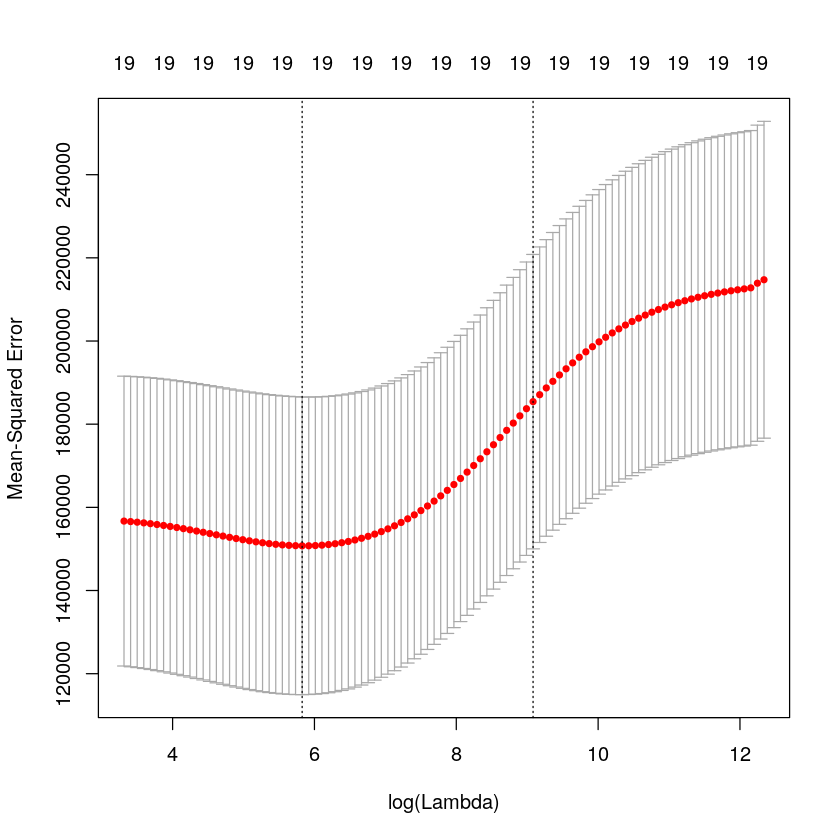

In [27]:
plot(cv.out) # Draw plot of training MSE as a function of lambda

What is the test MSE associated with this value of
$\lambda$?

In [28]:
ridge_pred = predict(ridge_mod, s = bestlam, newx = x_test) # Use best lambda to predict test data
mean((ridge_pred - y_test)^2) # Calculate test MSE

[1] 96839.6

This represents a further improvement over the test MSE that we got using
$\lambda = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of $\lambda$ chosen by cross-validation, and examine the coefficient
estimates.

In [29]:
out = glmnet(x, y, alpha = 0) # Fit ridge regression model on full dataset
predict(out, type = "coefficients", s = bestlam)[1:20,] # Display coefficients using lambda chosen by CV

(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 16.46736574   0.08032137   0.84704629   0.64006223   1.05843603   0.87928777 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
  1.60850791   1.44656580   0.01134814   0.05683777   0.40287164   0.11336424 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  0.11983351   0.05469381  21.63741439 -77.81340620   0.16376912   0.02843065 
      Errors   NewLeagueN 
 -1.32174192   9.21691091

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# 6.6.2 The Lasso
We saw that ridge regression with a wise choice of $\lambda$ can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we once again
use the `glmnet()` function; however, this time we use the argument `alpha=1`.
Other than that change, we proceed just as we did in fitting a ridge model:

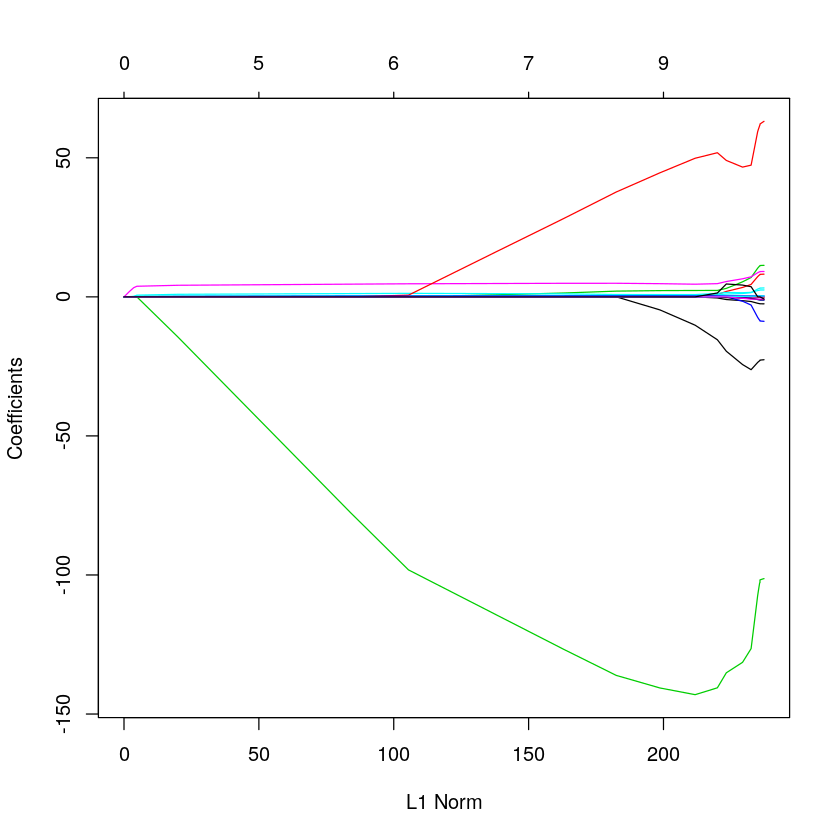

In [30]:
lasso_mod = glmnet(x_train, 
                   y_train, 
                   alpha = 1, 
                   lambda = grid) # Fit lasso model on training data

plot(lasso_mod)    # Draw plot of coefficients

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform cross-validation and compute the associated test error:

[1] 101400.3

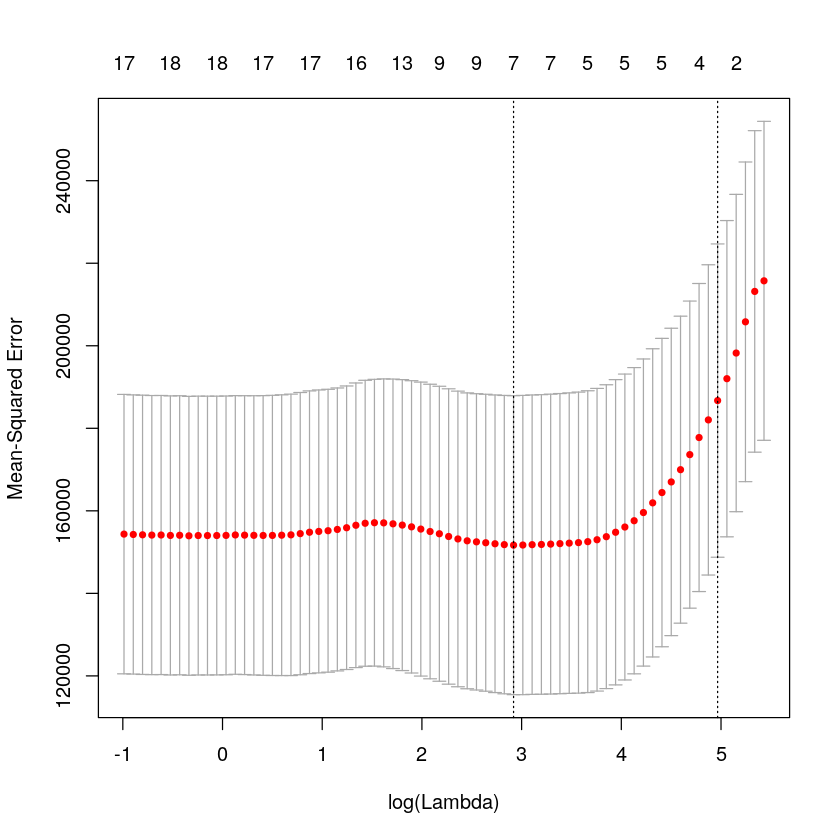

In [31]:
set.seed(1)
cv.out = cv.glmnet(x_train, y_train, alpha = 1) # Fit lasso model on training data
plot(cv.out) # Draw plot of training MSE as a function of lambda
bestlam = cv.out$lambda.min # Select lamda that minimizes training MSE
lasso_pred = predict(lasso_mod, s = bestlam, newx = x_test) # Use best lambda to predict test data
mean((lasso_pred - y_test)^2) # Calculate test MSE

This is substantially lower than the test set MSE of the null model and of
least squares, and very similar to the test MSE of ridge regression with $\lambda$
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 12 of
the 19 coefficient estimates are exactly zero:

In [32]:
out = glmnet(x, y, alpha = 1, lambda = grid) # Fit lasso model on full dataset
lasso_coef = predict(out, type = "coefficients", s = bestlam)[1:20,] # Display coefficients using lambda chosen by CV
lasso_coef

(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
  23.9819931    0.0000000    1.8524855    0.0000000    0.0000000    0.0000000 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
   2.1984435    0.0000000    0.0000000    0.0000000    0.0000000    0.2059877 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
   0.4099610    0.0000000    0.3519863 -100.3519551    0.2163792    0.0000000 
      Errors   NewLeagueN 
   0.0000000    0.0000000

Selecting only the predictors with non-zero coefficients, we see that the lasso model with $\lambda$
chosen by cross-validation contains only seven variables:

In [ ]:
lasso_coef[lasso_coef != 0] # Display only non-zero coefficients

# Your turn!
Now it's time to test out these approaches (ridge regression and the lasso) and evaluation methods (validation set, cross validation) on other datasets. You may want to work with a team on this portion of the lab.
You may use any of the datasets included in ISLR, or choose one from the UCI machine learning repository (http://archive.ics.uci.edu/ml/datasets.html). Download a dataset, and try to determine the optimal set of parameters to use to model it! You are free to use the same dataset you used in Lab 9, or you can choose a new one.

In [ ]:
# Your code here

To get credit for this lab, post your responses to the following questions:
 - Which dataset did you choose?
 - What was your response variable (i.e. what were you trying to model)?
 - Did you expect ridge regression to outperform the lasso, or vice versa?
 - Which predictors turned out to be important in the final model(s)?
 
to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=259464